In [1]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
#%matplotlib notebook
#import matplotlib.pylab as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd
import multiprocessing
from joblib import Parallel, delayed
num_cores = multiprocessing.cpu_count()
if num_cores == 32:
    num_cores = 24  # lsst-dev - don't use all the cores, man.
elif num_cores == 8:
    num_cores = 3
elif num_cores == 4:
    num_cores = 2
print num_cores

import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

import warnings
warnings.filterwarnings('ignore')

import diffimTests as dit

3


In [2]:
# Set up console so we can reattach via terminal ipython later. See:
# https://stackoverflow.com/questions/19479645/using-ipython-console-along-side-ipython-notebook

%qtconsole

# Then do `ipython console --existing` in a terminal to connect and have access to same data!
# But note, do not do CTRL-D in that terminal or it will kill the kernel!

## New topic: double gaussian psf...

1.0


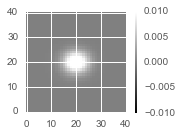

In [3]:
reload(dit)
psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.9, sigma_x=3.0, sigma_y=3.5)
print psf.sum()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

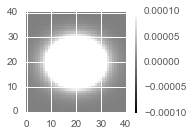

In [4]:
dit.plotImageGrid((psf,), clim=(-0.0001, 0.0001))

(ixx=12.9123732203, iyy=9.48680733984, ixy=0.0)
(ixx=12.2497431042, iyy=8.99978630007, ixy=-0.0)
(ixx=13.7640474984, iyy=10.1123404965, ixy=-0.0)


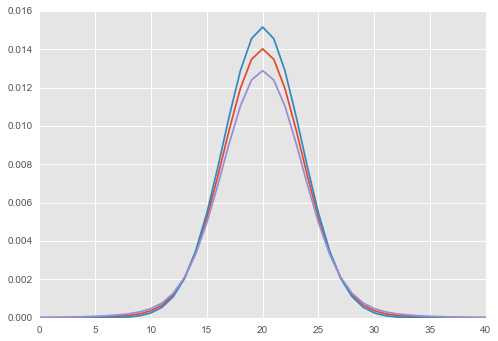

In [5]:
psf2 = dit.psf.singleGaussian2d(x0, y0, 0, 0, sigma_x=3.0, sigma_y=3.5, theta=0.)
psf3 = dit.psf.doubleGaussian2d(x0, y0, 0, 0, a=0.8, sigma_x=3.0, sigma_y=3.5)
print dit.afw.arrayToAfwPsf(psf).computeShape()
print dit.afw.arrayToAfwPsf(psf2).computeShape()
print dit.afw.arrayToAfwPsf(psf3).computeShape()
plt.plot(psf[20,:])
plt.plot(psf2[20,:])
plt.plot(psf3[20,:])

## Use `galsim` for Kolmogorov PSF...

9604
galsim.BoundsI(1,98,1,98) 98


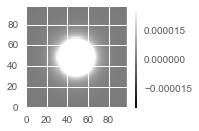

In [6]:
import galsim
#gsp = galsim.GSParams(folding_threshold=1.0/512., maximum_fft_size=12288)
psf = galsim.Kolmogorov(fwhm=3.5*0.2*2.355, flux=1) #, gsparams=gsp)
im = psf.drawImage(method='real_space', scale=0.2)
print im.image.array.size
bounds = im.getBounds()
print bounds, bounds.getXMax()
arr = im.image.array.reshape(bounds.getXMax(), bounds.getXMax())
dit.plotImageGrid((arr,))

1.6485
(ixx=13.9971286725, iyy=13.9971286725, ixy=0.27901747012)


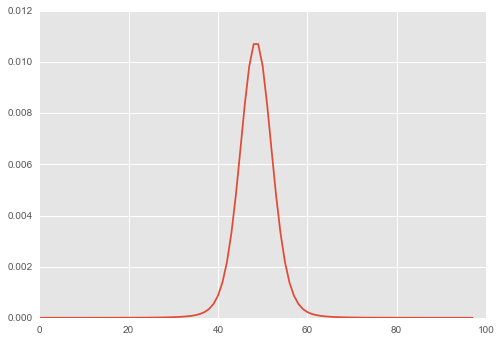

In [7]:
print psf.getFWHM()
print dit.afw.arrayToAfwPsf(arr).computeShape()
plt.plot(arr[bounds.getXMax()//2,:])

## Now a Moffat...

1.0
(ixx=14.1958993231, iyy=14.1958993231, ixy=0.0)


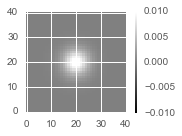

In [8]:
reload(dit)

psfSize = 21
x = np.arange(-psfSize+1, psfSize, 1)
y = x.copy()
y0, x0 = np.meshgrid(x, y)
psf = dit.psf.moffat2d(x0, y0, 0, 0, 3.5*2.355)  # fwhm = 2.355 * sigma
print psf.sum()
print dit.afw.arrayToAfwPsf(psf).computeShape()
dit.plotImageGrid((psf,), clim=(-0.01, 0.01))

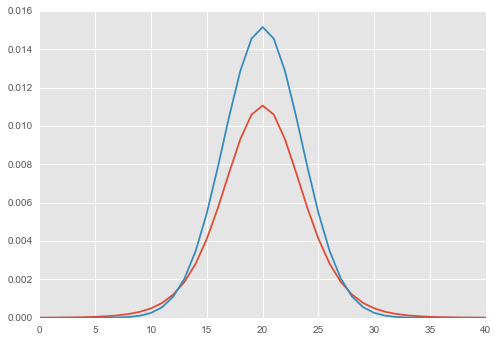

In [9]:
plt.plot(psf[20,:])
plt.plot(psf2[20,:])

## After adding these to `diffimTests.psf.makePsf` and `diffimTests.makeFakeImages`...

{'ZOGY': {'FP': 2, 'FN': 460, 'TP': 40}, 'ALstack': {'FP': 2, 'FN': 461, 'TP': 39}, 'SZOGY': {'FP': 3, 'FN': 461, 'TP': 39}, 'ALstack_decorr': {'FP': 2, 'FN': 461, 'TP': 39}}


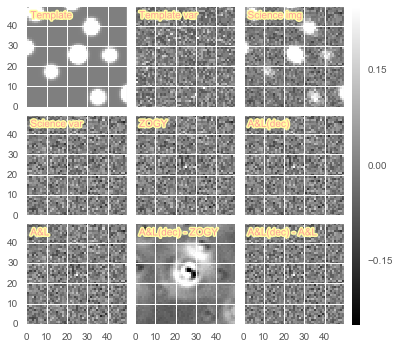

In [4]:
reload(dit)
testObj = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15.)

res = testObj.runTest(returnSources=True)
src = res['sources']
del res['sources']
print res

tmp = dit.catalogToDF(testObj.getCentroidsCatalog(transientsOnly=False))
#dit.sizeme(tmp.tail())
testObj.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 2, 'FN': 460, 'TP': 40}, 'ALstack': {'FP': 2, 'FN': 461, 'TP': 39}, 'SZOGY': {'FP': 3, 'FN': 461, 'TP': 39}, 'ALstack_decorr': {'FP': 2, 'FN': 461, 'TP': 39}}


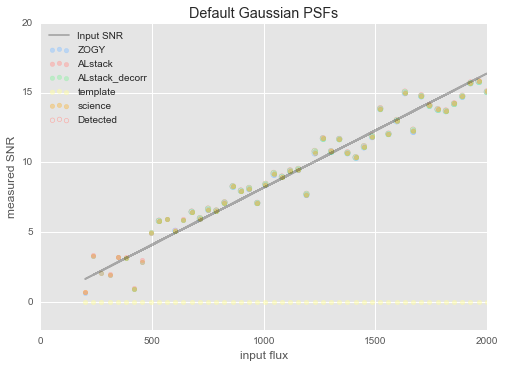

In [28]:
testObj.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20)
plt.title('Default Gaussian PSFs')

{'ZOGY': {'FP': 3, 'FN': 466, 'TP': 34}, 'ALstack': {'FP': 2, 'FN': 466, 'TP': 34}, 'SZOGY': {'FP': 6, 'FN': 468, 'TP': 32}, 'ALstack_decorr': {'FP': 2, 'FN': 466, 'TP': 34}}


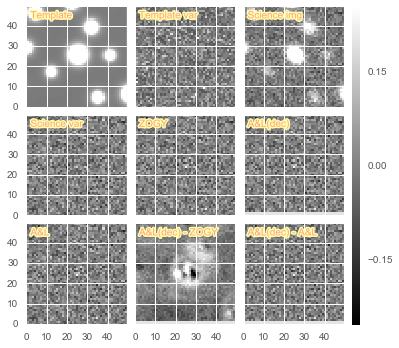

In [11]:
reload(dit)
testObj2 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='doubleGaussian')

res2 = testObj2.runTest(returnSources=True)
src2 = res2['sources']
del res2['sources']
print res2

testObj2.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 3, 'FN': 466, 'TP': 34}, 'ALstack': {'FP': 2, 'FN': 466, 'TP': 34}, 'SZOGY': {'FP': 6, 'FN': 468, 'TP': 32}, 'ALstack_decorr': {'FP': 2, 'FN': 466, 'TP': 34}}


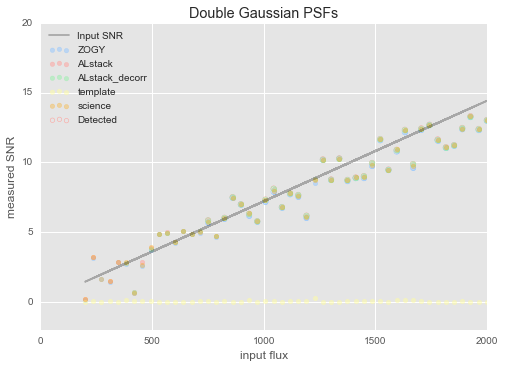

In [29]:
testObj2.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20)
plt.title('Double Gaussian PSFs')

{'ZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack': {'FP': 3, 'FN': 465, 'TP': 35}, 'SZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack_decorr': {'FP': 3, 'FN': 465, 'TP': 35}}


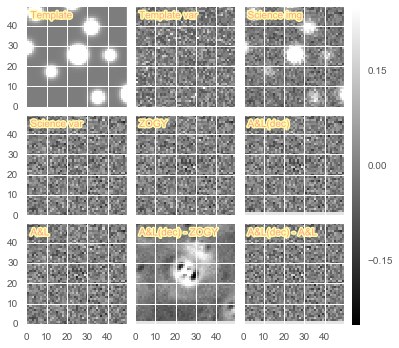

In [12]:
reload(dit)
testObj3 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='moffat')

res3 = testObj3.runTest(returnSources=True)
src3 = res3['sources']
del res3['sources']
print res3

testObj3.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack': {'FP': 3, 'FN': 465, 'TP': 35}, 'SZOGY': {'FP': 4, 'FN': 465, 'TP': 35}, 'ALstack_decorr': {'FP': 3, 'FN': 465, 'TP': 35}}


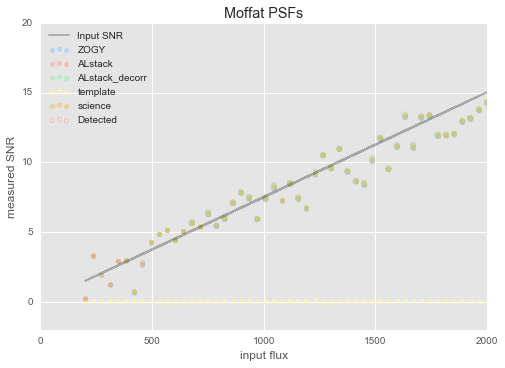

In [30]:
testObj3.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20)
plt.title('Moffat PSFs')

Kolmogorov works now, but is slow and there's still an issue with the A&L(dec) - ZOGY image.
Seems to be because of a 0.5-pixel offset in the psf.

In [2]:
reload(dit)
testObj4 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType='kolmogorov')

res4 = testObj4.runTest(returnSources=True)
src4 = res4['sources']
del res4['sources']
print res4

{'ZOGY': {'FP': 31, 'FN': 50, 'TP': 0}, 'ALstack': {'FP': 3, 'FN': 20, 'TP': 30}, 'SZOGY': {'FP': 25, 'FN': 50, 'TP': 0}, 'ALstack_decorr': {'FP': 3, 'FN': 21, 'TP': 29}}


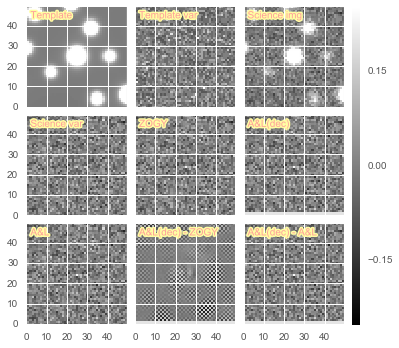

In [24]:
tmp = dit.catalogToDF(testObj.getCentroidsCatalog(transientsOnly=False))
testObj4.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);
#testObj4.doPlot();

In [15]:
print np.unravel_index(np.argmax(testObj.im2.psf), testObj.im2.psf.shape)
print np.unravel_index(np.argmax(testObj2.im2.psf), testObj2.im2.psf.shape)
print np.unravel_index(np.argmax(testObj3.im2.psf), testObj3.im2.psf.shape)
print np.unravel_index(np.argmax(testObj4.im2.psf), testObj4.im2.psf.shape)

print dit.afw.arrayToAfwPsf(testObj.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj2.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj3.im2.psf).computeShape()
print dit.afw.arrayToAfwPsf(testObj4.im2.psf).computeShape()

#dit.plotImageGrid((testObj.im2.psf, testObj2.im2.psf, testObj3.im2.psf, testObj4.im2.psf,))

(20, 20)
(20, 20)
(20, 20)
(20, 20)
(ixx=4.03994623804, iyy=4.03994623804, ixy=-0.799989278877)
(ixx=4.90711259462, iyy=4.90711259462, ixy=-0.971716519198)
(ixx=4.63417624379, iyy=4.63417624379, ixy=-0.0)
(ixx=4.54343857395, iyy=4.54343857395, ixy=-0.0)


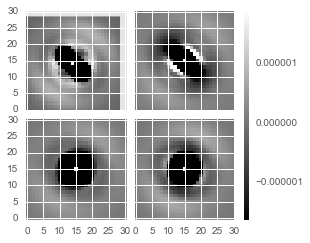

In [20]:
dit.plotImageGrid((testObj.ALres.decorrelationKernel, testObj2.ALres.decorrelationKernel,
                  testObj3.ALres.decorrelationKernel, testObj4.ALres.decorrelationKernel,))

This difference (below) is due to an issue probably with an offset in the PSFs.

{'ZOGY': {'FP': 10, 'FN': 472, 'TP': 28}, 'ALstack': {'FP': 7, 'FN': 469, 'TP': 31}, 'SZOGY': {'FP': 13, 'FN': 474, 'TP': 26}, 'ALstack_decorr': {'FP': 7, 'FN': 469, 'TP': 31}}


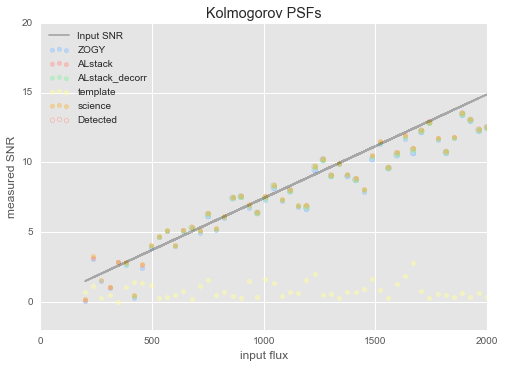

In [31]:
testObj4.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20)
plt.title('Kolmogorov PSFs')

In [33]:
print dit.psf.computeMoments(testObj.im1.psf)
print dit.psf.computeMoments(testObj2.im1.psf)
print dit.psf.computeMoments(testObj3.im1.psf)
print dit.psf.computeMoments(testObj4.im1.psf)

(20.0, 20.000000000000004)
(20.0, 20.000000000000007)
(20.0, 20.0)
(20.0, 20.0)


In [34]:
print dit.psf.computeMoments(testObj.im2.psf)
print dit.psf.computeMoments(testObj2.im2.psf)
print dit.psf.computeMoments(testObj3.im2.psf)
print dit.psf.computeMoments(testObj4.im2.psf)

(20.0, 20.000000000000004)
(20.0, 20.0)
(20.0, 20.0)
(20.0, 20.0)


# Now for "real" psfs from real images. Try this:

Box2I((0, 0), (511, 511))
(ixx=4.2937886539, iyy=4.68256779165, ixy=-1.00958235705)
2.0901753005


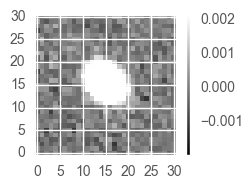

In [24]:
import lsst.afw.image as afwImage
# This image was a simulated image written out previously...
im = afwImage.ExposureF('test_imageDifference/test_dr1/deepDiff/im2/diffexp.fits')
print im.getBBox()
psf = im.getPsf()
print dit.afw.afwPsfToShape(psf, im)
print dit.afw.afwPsfToShape(psf, im).getDeterminantRadius()
dit.plotImageGrid((dit.afw.afwPsfToArray(psf, im),))

Box2I((0, 0), (2111, 4643))


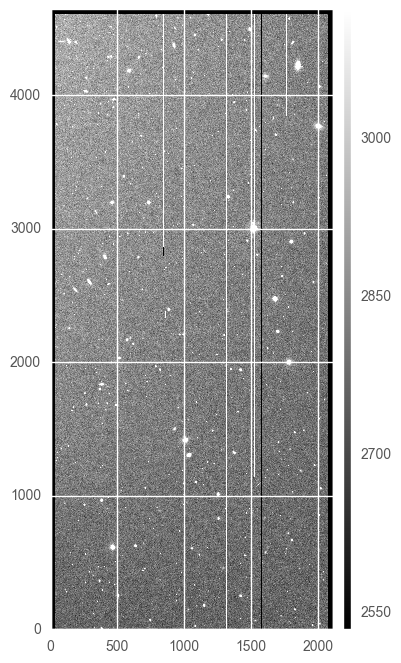

In [3]:
import os
import lsst.afw.image as afwImage
import diffimTests as dit

afwData = os.getenv('AFWDATA_DIR')
im = afwImage.ExposureF(afwData + '/CFHT/D4/cal-53535-i-797722_1.fits')
print im.getBBox()
dit.plotImageGrid((im.getMaskedImage().getImage(),), imScale=8.)

(ixx=2.98711664574, iyy=4.45245174118, ixy=-0.900905346003)


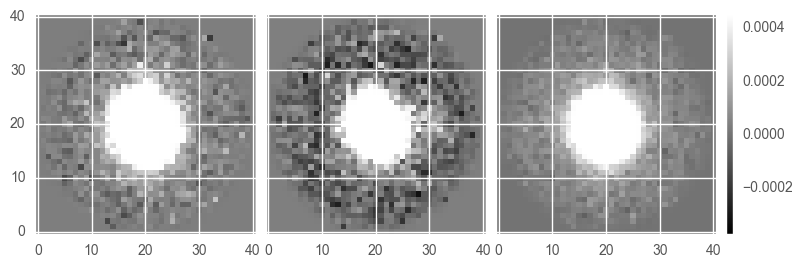

In [14]:
res = dit.tasks.doMeasurePsf(im, detectThresh=10.0, startSize=6.0, spatialOrder=2)
psf = res.psf #im.getPsf()
print dit.afw.afwPsfToShape(psf)
dit.plotImageGrid((dit.afw.afwPsfToArray(psf, im),
                   dit.afw.afwPsfToArray(psf, coord=[100,100]),
                  dit.afw.afwPsfToArray(psf, coord=[1500,4000])), imScale=3.)

<class 'lsst.meas.extensions.psfex.psfexLib.PsfexPsf'>
(ixx=2.98711664574, iyy=4.45245174118, ixy=-0.900905346003)


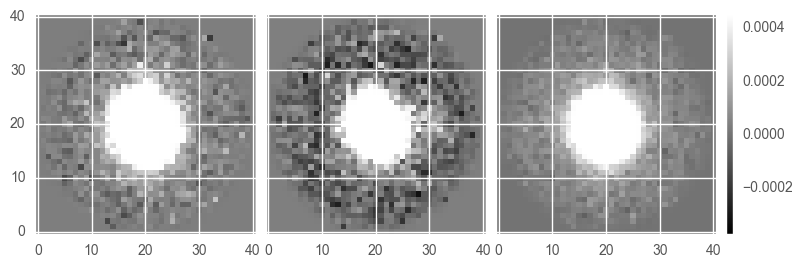

In [16]:
print type(psf)
psf.writeFits('cal-53535-i-797722_1_psf.fits')

import lsst.afw.detection as afwDet
psf2 = afwDet.Psf.readFits('cal-53535-i-797722_1_psf.fits')
print dit.afw.afwPsfToShape(psf2)
dit.plotImageGrid((dit.afw.afwPsfToArray(psf2, im),
                   dit.afw.afwPsfToArray(psf2, coord=[100,100]),
                  dit.afw.afwPsfToArray(psf2, coord=[1500,4000])), imScale=3.)

In [22]:
shape = dit.afw.afwPsfToShape(psf)
print shape
print shape.getTraceRadius() * 2.
shape.getDeterminantRadius() * 2.

(ixx=2.98711664574, iyy=4.45245174118, ixy=-0.900905346003)
3.85734841229


3.759727489503463

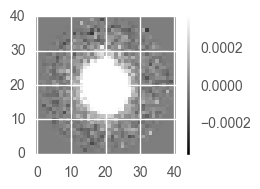

In [2]:
import os
afwData = os.getenv('AFWDATA_DIR')
filename = afwData + '/CFHT/D4/cal-53535-i-797722_1.fits'
psf = dit.psf.loadPsf(filename)
dit.plotImageGrid((psf,))

In [2]:
import diffimTests as dit
import glob, os

afwData = os.getenv('AFWDATA_DIR')
drpData = os.getenv('HOME') + '/DATA/'

filenames = glob.glob(afwData + '/CFHT/D4/*.fits')
# PsfEx doesn't seem to work well on many of the imsim simulated images.
filenames.extend(glob.glob(afwData + '/ImSim/postISR/v85751839-fr/s1/R23/S11/*.fits'))
filenames.extend(glob.glob(drpData + '/validation_data_decam/data/*/calexp/calexp*.fits'))
filenames.extend(glob.glob(drpData + './validation_data_cfht/data/calexp/06AL01/D3/2006-*/r/calexp*.fits'))

psfs = {}
for filename in filenames:
    if filename.find('small') > 0:
        continue
    print filename
    try:
        psfs[filename], source = dit.psf.loadPsf(filename, asArray=False, forceReMeasure=True)
        print source, dit.afw.afwPsfToShape(psfs[filename])
    except Exception as e:
        print e

/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_1.fits
measured (ixx=2.94816469033, iyy=4.45738762979, ixy=-0.92068890118)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_1_tmpl.fits
measured (ixx=3.64391908276, iyy=4.02471747415, ixy=-0.18133585555)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_2.fits
measured (ixx=2.55937027591, iyy=3.93038772842, ixy=-0.502375296895)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_2_tmpl.fits
measured (ixx=3.39782342322, iyy=3.68717056065, ixy=-0.0742932363751)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_3.fits
measured (ixx=2.28475730023, iyy=3.45907719925, ixy=-0.183215104756)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_3_tmpl.fits
measured (ixx=3.28642181602, iyy=3.48807236631, ixy=0.0248749106604)
/Users/dreiss/lsstsw/stack

In [3]:
import diffimTests as dit
import glob, os

afwData = os.getenv('AFWDATA_DIR')
drpData = os.getenv('HOME') + '/DATA/'

#fnames = glob.glob('./psfLib/*.fits')
#fnames = [fn.replace('_psf', '') for fn in fnames]
filenames = glob.glob(afwData + '/CFHT/D4/*.fits')
# PsfEx doesn't seem to work well on the imsim simulated images.
filenames.extend(glob.glob(afwData + '/ImSim/postISR/v85751839-fr/s1/R23/S11/*.fits'))
filenames.extend(glob.glob(drpData + '/validation_data_decam/data/*/calexp/calexp*.fits'))
filenames.extend(glob.glob(drpData + './validation_data_cfht/data/calexp/06AL01/D3/2006-*/r/calexp*.fits'))

psfs = {}
for filename in filenames:
    #print filename
    try:
        psf, source = dit.psf.loadPsf(filename, asArray=False)
        if psf is not None:
            print filename, dit.afw.afwPsfToShape(psf)
            psfs[filename] = psf
    except Exception as e:
        pass
        #print e
        
print len(psfs)

/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_1.fits (ixx=2.94816469033, iyy=4.45738762979, ixy=-0.92068890118)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_1_tmpl.fits (ixx=3.64391908276, iyy=4.02471747415, ixy=-0.18133585555)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_2.fits (ixx=2.55937027591, iyy=3.93038772842, ixy=-0.502375296895)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_2_tmpl.fits (ixx=3.39782342322, iyy=3.68717056065, ixy=-0.0742932363751)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_3.fits (ixx=2.28475730023, iyy=3.45907719925, ixy=-0.183215104756)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_3_tmpl.fits (ixx=3.28642181602, iyy=3.48807236631, ixy=0.0248749106604)
/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797

58


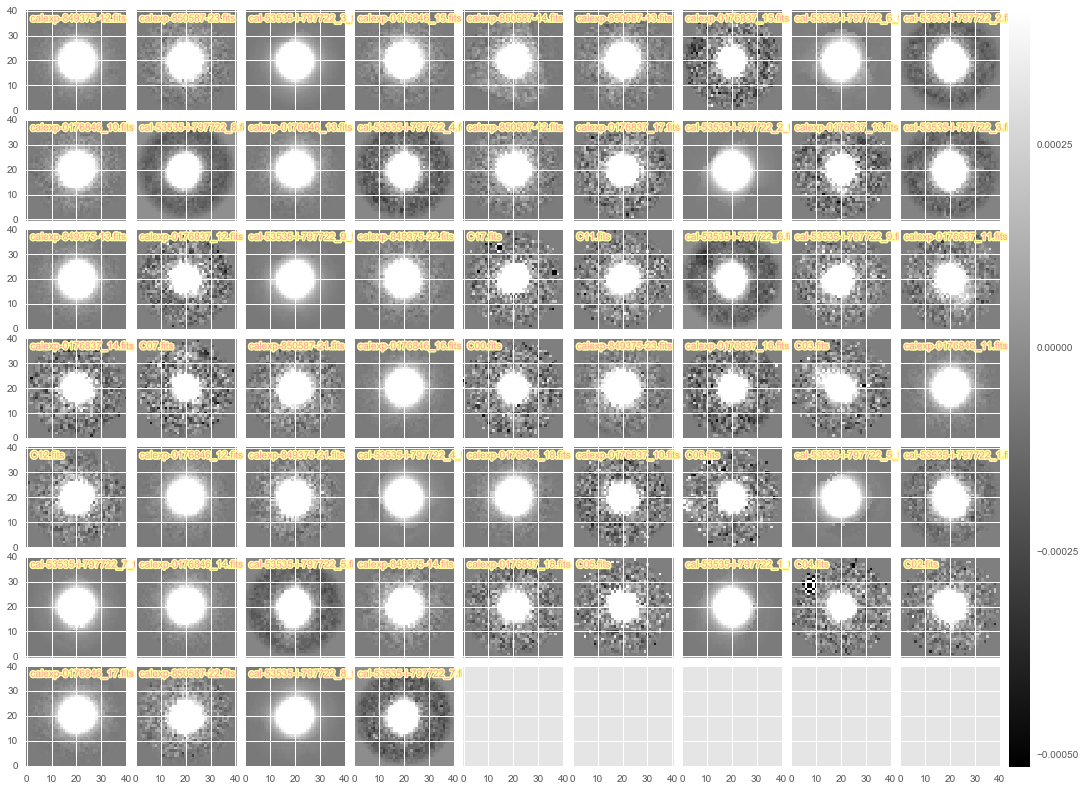

In [4]:
psftmp = [dit.afw.afwPsfToArray(psfs[key]) for key in psfs]
psftitles = [os.path.basename(key) for key in psfs]
psftitles = [t for i,t in enumerate(psftitles) if psftmp[i] is not None]
psftmp = [p for p in psftmp if p is not None]
print len(psftmp)
#print psftitles
dit.plotImageGrid(psftmp, titles=psftitles)

In [5]:
print [p[2,20] for p in psftmp]

[1.2173216418887023e-05, 4.3942891352344304e-06, 2.4577093427069485e-05, 3.2879343052627519e-05, 9.006751497508958e-06, 3.0170473110047169e-05, 0.0001870377454906702, 7.333381290663965e-06, -3.8410082197515294e-05, 6.6732478444464505e-05, -6.5534986788406968e-05, -1.6137440979946405e-05, -5.4239466408034787e-05, 7.02538454788737e-05, -1.2948247785971034e-05, 5.9170229178562295e-06, -7.3804068961180747e-05, -1.0409128208266338e-06, 3.0587594665121287e-05, -1.3578855941887014e-05, 2.0596151443896815e-05, -5.9130466070200782e-06, -0.00014825211837887764, 2.3813077859813347e-05, -0.00010344671318307519, 2.3191390937427059e-05, 5.2038235480722506e-06, -0.00021368361194618046, 1.9561690351110883e-05, 3.7934973079245538e-05, -1.7904139895108528e-06, -8.9519962784834206e-05, 6.7771368776448071e-05, 0.00018110223754774779, 5.2710271120304242e-05, 3.2349405955756083e-05, -8.0632235039956868e-06, 1.516520882205441e-07, 1.0832367479451932e-05, 2.0386041796882637e-05, 8.253090527432505e-06, -5.4026

Are the negative regions surrounding some PSFs going to be a problem?

Seems a pretty small effect.

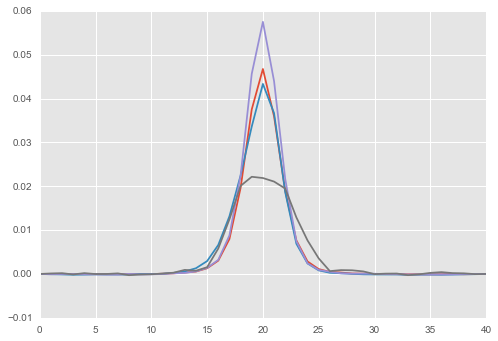

In [6]:
plt.plot(psftmp[8][20,:])
plt.plot(psftmp[10][20,:])
plt.plot(psftmp[12][20,:])
plt.plot(psftmp[50][20,:])

## OK now let's figure out how to make the fake image generator use the real PSFS.

Still needs work, I think there's a 1-pixel offset.

Also, need to be able to pass different PSFs for template and science (right now it uses the same one!)

Question - how and whether to use spatial variation.

<class 'lsst.afw.detection.detectionLib.Psf'>
True
<type 'numpy.ndarray'>
True


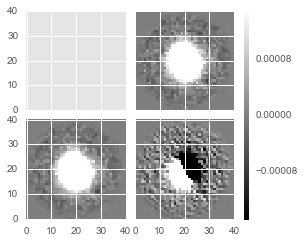

In [2]:
filename = '/Users/dreiss/lsstsw/stack/DarwinX86/afwdata/2.2016.10+7/CFHT/D4/cal-53535-i-797722_1.fits'
psf, source = dit.psf.loadPsf(filename, asArray=False)
print type(psf)
from lsst.afw.detection import Psf
print isinstance(psf, Psf)
psfImg = dit.afw.afwPsfToArray(psf)
print type(psfImg)
print isinstance(psfImg, np.ndarray)
psfImg2 = dit.afw.afwPsfToArray(psf, centroid=[0.5, 0.5])
dit.plotImageGrid((psf, psfImg, psfImg2, psfImg2-psfImg))

{'ZOGY': {'FP': 12, 'FN': 473, 'TP': 27}, 'ALstack': {'FP': 13, 'FN': 473, 'TP': 27}, 'SZOGY': {'FP': 14, 'FN': 473, 'TP': 27}, 'ALstack_decorr': {'FP': 14, 'FN': 474, 'TP': 26}}


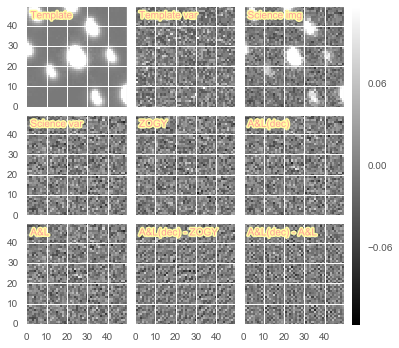

In [5]:
reload(dit)
testObj5 = dit.diffimTests.DiffimTest(n_sources=500, sourceFluxRange=(2000, 20000), 
                         varFlux2=np.linspace(200, 2000, 50),
                         #varFlux2=np.repeat(500., 50),
                         templateNoNoise=True, skyLimited=True,
                         avoidAllOverlaps=15., psfType=psf)

res5 = testObj5.runTest(returnSources=True)
src5 = res5['sources']
del res5['sources']
print res5

testObj5.doPlot(centroidCoord=[tmp.centroid_y.values[300], tmp.centroid_x.values[300]]);

{'ZOGY': {'FP': 12, 'FN': 473, 'TP': 27}, 'ALstack': {'FP': 13, 'FN': 473, 'TP': 27}, 'SZOGY': {'FP': 14, 'FN': 473, 'TP': 27}, 'ALstack_decorr': {'FP': 14, 'FN': 474, 'TP': 26}}


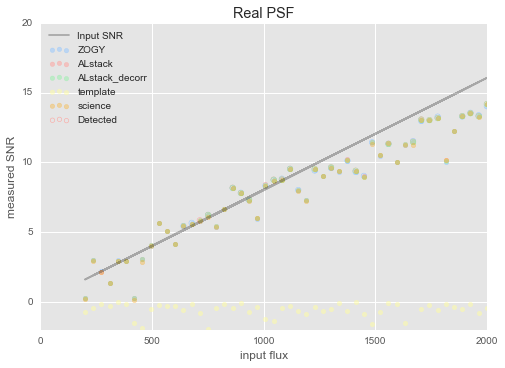

In [6]:
testObj5.doPlotWithDetectionsHighlighted(transientsOnly=True, divideByInput=False, addPresub=True)
plt.xlim(0, 2000)
plt.ylim(-2, 20)
plt.title('Real PSF')